# Sturctural analysis

Searching for config-files in the git-repos and their subfolders

In [2]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_config_details(directory):
    config_files_info = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)

        for root, dirs, files in os.walk(subdirectory_path):
            for file in files:
                if file.endswith('.config'):
                    config_file_name = file
                    config_file_path = os.path.join(root, file)
                    with open(config_file_path, 'r') as f:
                        line_count = sum(1 for line in f)
                    config_files_info.append((folder_name, config_file_name, line_count))

    return config_files_info

In [4]:
def write_config_info_to_csv(config_info, csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        fieldnames = ['pipeline', 'config_file_name', 'line_count']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for folder_name, config_file_name, line_count in config_info:
            writer.writerow({'pipeline': folder_name, 'config_file_name': config_file_name, 'line_count': line_count})

    print(f"Results written to: {csv_file_path}")

In [5]:
directory_path = './git_repos/'
csv_file_path = './results/config_file_details.csv'

config_details = get_config_details(directory_path)
write_config_info_to_csv(config_details, csv_file_path)

Results written to: ./results/config_file_details.csv


In [6]:
df = pd.read_csv('./results/config_file_details.csv')
df.describe()

,line_count
count,1029.000000
mean,104.898931
std,159.885269
min,0.000000
25%,23.000000
50%,37.000000
75%,84.000000
max,1228.000000


In [7]:
sorted_df = df.sort_values(by='line_count', ascending=True)

print("Sorted DataFrame based on line_count (descending order):")
print(sorted_df)

Sorted DataFrame based on line_count (descending order):
            pipeline         config_file_name  line_count
335         fetchngs          nextflow.config           0
500      metatdenovo          igenomes.config           0
618   phageannotator          nextflow.config           0
653   phageannotator          nextflow.config           2
658   phageannotator          nextflow.config           2
...              ...                      ...         ...
36           atacseq           modules.config         976
183        cutandrun           modules.config        1047
1021      viralrecon  modules_illumina.config        1053
823           rnaseq           modules.config        1167
398            hicar           modules.config        1228

[1029 rows x 3 columns]


In [8]:
pipeline_nextflow = df[df['config_file_name'] == 'nextflow.config']['pipeline'].value_counts()
pipeline_configs = df.groupby('pipeline')['config_file_name'].count().sort_values(ascending=False)

print("Number of pipelines with config:")
print(len(pipeline_configs))
print("Number of folder_name with nextflow.config:")
print(pipeline_nextflow)

Number of pipelines with config:
94
Number of folder_name with nextflow.config:
pipeline
phageannotator           52
fetchngs                 21
callingcards              8
multiplesequencealign     5
cutandrun                 4
                         ..
gwas                      1
genomeskim                1
genomeassembler           1
genomeannotator           1
viralrecon                1
Name: count, Length: 94, dtype: int64


- Total: 1029 config-files
- Every pipeline has at least 1 nextflow.config
- 70 config-files in sarek pipeline
- Config details: average of 104 lines, a median of 37 lines, and a 75th percentile of 84 lines. We can see that some configuration files contain a huge amount of lines, the biggest configuration file includes a total of 1228 lines.

In [20]:
pipeline_counts = df.groupby('pipeline').agg({'config_file_name' : 'count'})
pipeline_counts

,config_file_name
pipeline,
airrflow,14
ampliseq,19
atacseq,7
bacass,9
bactmap,5
...,...
taxprofiler,18
variantcatalogue,6
vipr,4


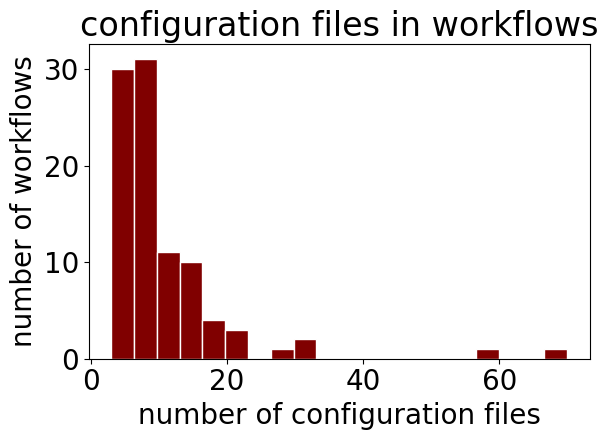

In [25]:
plt.rc('font', size=20)
plt.hist(pipeline_counts, bins=20,color='maroon', edgecolor='white')
plt.xlabel('number of configuration files')
plt.ylabel('number of workflows')
plt.title('configuration files in workflows')
plt.tight_layout()
plt.savefig(f'./plots/config_file_counts.png', format="png", bbox_inches='tight')
plt.show()

Task: Proportion of if-conditions in config-files. maybe modify and search for different regular expression-patterns (?)

In [ ]:
def count_and_collect_occurrences(directory, pattern, config=None):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)
        print(f"Processing pipeline: {folder_name}")

        subdirectory_occurrences = 0
        lines_with_occurrences = []

        for root, _, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                
                if filename.endswith('.config'):
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        content = file.readlines()

                        occurrences = 0

                        for line_number, line in enumerate(content, start=1):
                            if re.search(pattern, line):
                                occurrences += 1
                                lines_with_occurrences.append((line_number, line.strip()))

                        subdirectory_occurrences += occurrences

        result_list.append({
            'subdirectory_path': folder_name,
            'total_occurrences': subdirectory_occurrences,
            'lines_with_occurrences': lines_with_occurrences
        })

    return result_list

def write_results_to_file(result_list, output_file_path, pattern):
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for result in result_list:
            output_file.write(f'Total occurrences of "{pattern.pattern}" in {result["subdirectory_path"]}: {result["total_occurrences"]}\n')
            
            for line_number, line_content in result['lines_with_occurrences']:
                output_file.write(f'  - Line {line_number}: {line_content}\n')

def write_results_to_csv(result_list, output_csv_path, pattern):
    header = ['pipeline', 'if_occurences']

    with open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)

        for result in result_list:
            writer.writerow([result['subdirectory_path'], result['total_occurrences']])

We just search in the config-files for the if-conditions

In [ ]:
directory_path = './git_repos/'
pattern_to_search = re.compile(r'\bif\s*\(')

if_in_config = './results/if_condition_in_config.txt'
output_csv_path = './results/if_condition_in_config.csv'

result_list = count_and_collect_occurrences(directory_path, pattern_to_search, config=True)
write_results_to_file(result_list, include_file_path, pattern_to_search)

print(f'Results written to: {if_in_config}')

result_list = count_and_collect_occurrences(directory_path, pattern_to_search, config=True)
write_results_to_csv(result_list, output_csv_path, pattern_to_search)

print(f'Results written to: {output_csv_path}')

In [15]:
import pandas as pd

df_if_cond = pd.read_csv('./results/if_condition_in_config.csv')
df_if_cond

,pipeline,if_occurences
0,airrflow,6
1,ampliseq,5
2,atacseq,30
3,bacass,11
4,bactmap,5
...,...,...
89,taxprofiler,6
90,variantcatalogue,6
91,vipr,5
92,viralintegration,6


Pipelines without include occurences

In [5]:
def count_and_collect_occurrences(directory, pattern):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)
        print(f"Processing pipeline: {folder_name}")

        subdirectory_occurrences = 0
        lines_with_occurrences = []

        for root, _, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)

                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.readlines()

                    occurrences = 0

                    for line_number, line in enumerate(content, start=1):
                        if re.search(pattern, line):
                            occurrences += 1
                            lines_with_occurrences.append((line_number, line.strip()))

                    subdirectory_occurrences += occurrences

        result_list.append({
            'subdirectory_path': folder_name,
            'total_occurrences': subdirectory_occurrences,
            'lines_with_occurrences': lines_with_occurrences
        })

    return result_list

def write_results_to_file(result_list, output_file_path, pattern):
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for result in result_list:
            output_file.write(f'Total occurrences of "{pattern}" in {result["subdirectory_path"]}: {result["total_occurrences"]}\n')
            for line_number, line_content in result['lines_with_occurrences']:
                output_file.write(f'  - Line {line_number}: {line_content}\n')
                
    print(f'Results written to: {output_file_path}')

def write_results_to_csv(result_list, output_csv_path):
    header = ['pipeline', 'include_occurrences']

    with open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)

        for result in result_list:
            writer.writerow([result['subdirectory_path'], result['total_occurrences']])
            
    print(f'Results written to CSV: {output_csv_path}')

Usage of include-statement in subworkflows -> can be found in directory: ./git_repos\"pipeline"\subworkflows\local\

In [ ]:
directory_path = './git_repos/'
pattern_to_search = re.compile(r'\binclude\s*{')
output_file_path = './results/include_occurrences.txt'
output_csv_path = './results/include_occurrences.csv'

result_list = count_and_collect_occurrences(directory_path, pattern_to_search)
write_results_to_file(result_list, output_file_path, pattern_to_search)
write_results_to_csv(result_list, output_csv_path)

In [1]:
import pandas as pd

df_inc_cond = pd.read_csv('./results/include_occurrences.csv')

total_include = df_inc_cond['include_occurrences'].sum()
print("Total count of includes:", total_include)

Total count of includes: 4094


In [2]:
df_inc_cond.describe()

,include_occurrences
count,94.000000
mean,43.553191
std,48.114250
min,0.000000
25%,9.250000
50%,32.000000
75%,62.500000
max,250.000000


In [12]:
pipelines_with_include = df_inc_cond[df_inc_cond['include_occurrences'] != 0]
#pd.set_option('display.max_rows', None)
pipelines_with_include

,pipeline,include_occurences
0,airrflow,73
1,ampliseq,124
2,atacseq,86
3,bacass,34
4,bactmap,55
...,...,...
88,ssds,33
89,taxprofiler,78
90,variantcatalogue,45
92,viralintegration,23


In [14]:
filtered_df = df_inc_cond[df_inc_cond['include_occurrences'] == 0]

print(f"Rows (pipelines) where include_occurences is 0: {len(filtered_df)}")
print(filtered_df)

Rows (pipelines) where include_occurences is 0: 20
           pipeline  include_occurences
6           cageseq                   0
12          coproid                   0
16        crisprvar                   0
18  ddamsproteomics                   0
19      deepvariant                   0
21     denovohybrid                   0
23    diaproteomics                   0
25       dualrnaseq                   0
26            eager                   0
28           exoseq                   0
40           imcyto                   0
42         kmermaid                   0
44          lncpipe                   0
53         mnaseseq                   0
59      neutronstar                   0
62             pgdb                   0
67    proteomicslfq                   0
83          slamseq                   0
84        smartseq2                   0
91             vipr                   0


# Parse the repos for wildcards in config or nf files
Process wildcards documentation can be found here: https://www.nextflow.io/docs/latest/process.html

- During exploration, insights gained led to skipping certain directories

- observation: .yml-files contain most of wildcard occurences

- to-do: check for raredesease repo

In [16]:
import os
import re
import csv
import pandas as pd

def find_widlcards_in_processes(directory, pattern_list, output_file_name):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)

        for root, dirs, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                
                if filename.endswith('.config') or filename.endswith('.nf'):
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        lines = file.readlines()

                    for line_num, line in enumerate(lines):
                        stripped_line = line.strip()

                        if line.strip().startswith('#') or line.strip().startswith('//') or line.strip().startswith('*'):
                                continue

                        for pattern in pattern_list:
                            
                            pattern_csv = pattern
                            regex_pattern = re.compile(pattern)
                            if regex_pattern.search(stripped_line):
                                result_list.append([folder_name, pattern_csv, file_path, line_num+1, stripped_line])
                                #print(f'Wildcard found {pattern} with content: {stripped_line}')

    with open(f'./results/{output_file_name}.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['pipeline', 'wildcard_pattern', 'file_path', 'line_number', 'line_content'])
        writer.writerows(result_list)

directory_path = './git_repos'

pattern_list = pattern_list = [r'(?<!`)\*\.', r'\?\.', r'\?\?\.']
# pattern_list = ['Channel.of', 'fromPath', 'Channel.from']
output_file_name = 'wildcard_occurrences'

find_widlcards_in_processes(directory_path, pattern_list, output_file_name)

In [2]:
import pandas as pd

# 4800 in nf and config files
wildcards = pd.read_csv('./results/wildcard_occurrences.csv')
wildcards

,pipeline,wildcard_pattern,file_path,line_number,line_content
0,airrflow,(?<!`)\*\.,./git_repos\airrflow\conf\modules.config,53,"pattern: ""*.{html,json,log}"""
1,airrflow,(?<!`)\*\.,./git_repos\airrflow\conf\modules.config,59,"pattern: ""*.fastp.fastq.gz"""
2,airrflow,(?<!`)\*\.,./git_repos\airrflow\modules\local\fastqc_post...,15,"tuple val(meta), path(""*.html""), emit: html"
3,airrflow,(?<!`)\*\.,./git_repos\airrflow\modules\local\fastqc_post...,16,"tuple val(meta), path(""*.zip"") , emit: zip"
4,airrflow,(?<!`)\*\.,./git_repos\airrflow\modules\local\parse_logs.nf,26,"path ""Table*.tsv"", emit:tables"
...,...,...,...,...,...
4975,viralrecon,(?<!`)\*\.,./git_repos\viralrecon\modules\nf-core\unicycl...,14,"tuple val(meta), path('*.scaffolds.fa.gz'), em..."
4976,viralrecon,(?<!`)\*\.,./git_repos\viralrecon\modules\nf-core\unicycl...,15,"tuple val(meta), path('*.assembly.gfa.gz'), em..."
4977,viralrecon,(?<!`)\*\.,./git_repos\viralrecon\modules\nf-core\unicycl...,16,"tuple val(meta), path('*.log') , em..."
4978,viralrecon,(?<!`)\*\.,./git_repos\viralrecon\modules\nf-core\vcflib\...,15,"tuple val(meta), path(""*.gz""), emit: vcf"


In [3]:
print(f'Total wildcard occurences in pipelines: {len(wildcards)}')

Total wildcard occurences in pipelines: 4980


In [4]:
pd.set_option('display.max_rows', None)
pipelines = wildcards.groupby('pipeline').agg({'file_path': 'count'})
pipelines

,file_path
pipeline,
airrflow,30
ampliseq,135
atacseq,127
bacass,63
bactmap,88
bamtofastq,23
cageseq,20
callingcards,68
chipseq,109


In [8]:
print(f'Total pipelines with wildcards: {len(pipelines)}')

Total pipelines with wildcards: 92


In [ ]:
pd.set_option('display.max_rows', False)

In [19]:
count_pipelines = wildcards['pipeline'].nunique()
print(f'{count_pipelines} pipelines use wildcards in config or processes.')

92 pipelines use wildcards in config or processes


In [20]:
wildcards_pipeline = wildcards.groupby('pipeline').size().reset_index(name='wildcard_count')
wildcards_pipeline.describe()

,wildcard_count
count,92.000000
mean,54.130435
std,52.917148
min,1.000000
25%,13.000000
50%,41.500000
75%,67.250000
max,244.000000


# If-conditions inside or outside a process

In [23]:
import os
import re
import csv

def find_if_conditions(directory, result_dir):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)

        subdirectory_if_inside = 0
        subdirectory_if_outside = 0
        
        if_patterns = [r'\bif\s*\(', r'\bif\s*\[', r'\bif\s*\{']

        for root, dirs, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                
                if filename.endswith(('.nf', '.config')):
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        content = file.readlines()

                        brace_stack = []
                        process_flag = False  
                        process_name = None

                        for i, line in enumerate(content):
                            stripped_line = line.strip()
                            
                            if line.strip().startswith(('#', '//', '*')):
                                continue
                                
                            process_pattern = r'process\s+(\w+)\s*{'

                            if re.search(process_pattern, stripped_line):
                                process_flag = True
                                process_match = re.search(process_pattern, stripped_line)
                                if process_match:
                                    process_name = process_match.group(1)
                                    print(f'Process {process_name} in filepath {file_path}')

                            if '{' in stripped_line:
                                brace_stack.append('{')

                            if '}' in stripped_line:
                                if brace_stack:
                                    brace_stack.pop()
                                    if not brace_stack and process_flag:
                                        process_flag = False
                                        

                            for if_pattern in if_patterns:
                                if re.search(if_pattern, stripped_line, re.IGNORECASE):
                                    context = "INSIDE" if process_flag else "OUTSIDE"
                                    if process_flag:
                                        subdirectory_if_inside += 1
                                    else:
                                        subdirectory_if_outside += 1
                                    result_list.append((folder_name, process_name, context, file_path, i + 1, stripped_line))

        with open(f'./results/if_conditions_processes.csv', 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['Pipeline', 'Process Name', 'Inside/Outside Process', 'File Path', 'Line Number', 'Line Content'])
            csv_writer.writerows(result_list)


In [24]:
directory = './git_repos/'
result_dir = 'reviewed_results'
find_if_conditions(directory, result_dir)

Process FASTQC_POSTASSEMBLY in filepath ./git_repos/airrflow\modules\local\fastqc_postassembly.nf
Process FETCH_DATABASES in filepath ./git_repos/airrflow\modules\local\fetch_databases.nf
Process GUNZIP in filepath ./git_repos/airrflow\modules\local\gunzip.nf
Process MERGE_UMI in filepath ./git_repos/airrflow\modules\local\merge_UMI.nf
Process PARSE_LOGS in filepath ./git_repos/airrflow\modules\local\parse_logs.nf
Process RENAME_FASTQ in filepath ./git_repos/airrflow\modules\local\rename_fastq.nf
Process RENAME_FILE in filepath ./git_repos/airrflow\modules\local\rename_file.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/airrflow\modules\local\samplesheet_check.nf
Process UNZIP_DB in filepath ./git_repos/airrflow\modules\local\unzip_db.nf
Process AIRRFLOW_REPORT in filepath ./git_repos/airrflow\modules\local\airrflow_report\airrflow_report.nf
Process CHANGEO_ASSIGNGENES in filepath ./git_repos/airrflow\modules\local\changeo\changeo_assigngenes.nf
Process CHANGEO_CONVERTDB_FASTA in

Process QIIME2_DIVERSITY_BETAORD in filepath ./git_repos/ampliseq\modules\local\qiime2_diversity_betaord.nf
Process QIIME2_DIVERSITY_CORE in filepath ./git_repos/ampliseq\modules\local\qiime2_diversity_core.nf
Process QIIME2_EXPORT_ABSOLUTE in filepath ./git_repos/ampliseq\modules\local\qiime2_export_absolute.nf
Process QIIME2_EXPORT_RELASV in filepath ./git_repos/ampliseq\modules\local\qiime2_export_relasv.nf
Process QIIME2_EXPORT_RELTAX in filepath ./git_repos/ampliseq\modules\local\qiime2_export_reltax.nf
Process QIIME2_EXTRACT in filepath ./git_repos/ampliseq\modules\local\qiime2_extract.nf
Process QIIME2_FEATURETABLE_GROUP in filepath ./git_repos/ampliseq\modules\local\qiime2_featuretable_group.nf
Process QIIME2_FILTERSAMPLES in filepath ./git_repos/ampliseq\modules\local\qiime2_filtersamples.nf
Process QIIME2_FILTERTAXA in filepath ./git_repos/ampliseq\modules\local\qiime2_filtertaxa.nf
Process QIIME2_INASV in filepath ./git_repos/ampliseq\modules\local\qiime2_inasv.nf
Process QI

Process UMITOOLS_EXTRACT in filepath ./git_repos/atacseq\modules\nf-core\umitools\extract\main.nf
Process UNTAR in filepath ./git_repos/atacseq\modules\nf-core\untar\main.nf
Process DFAST in filepath ./git_repos/bacass\modules\local\dfast.nf
Process KRAKEN2_DB_PREPARATION in filepath ./git_repos/bacass\modules\local\kraken2_db_preparation.nf
Process MEDAKA in filepath ./git_repos/bacass\modules\local\medaka.nf
Process NANOPOLISH in filepath ./git_repos/bacass\modules\local\nanopolish.nf
Process PYCOQC in filepath ./git_repos/bacass\modules\local\pycoqc.nf
Process UNICYCLER in filepath ./git_repos/bacass\modules\local\unicycler.nf
Process BAKTA_BAKTA in filepath ./git_repos/bacass\modules\nf-core\bakta\bakta\main.nf
Process BAKTA_BAKTADBDOWNLOAD in filepath ./git_repos/bacass\modules\nf-core\bakta\baktadbdownload\main.nf
Process CANU in filepath ./git_repos/bacass\modules\nf-core\canu\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/bacass\modules\nf-core\custom\dumps

Process PICARD_COLLECTMULTIPLEMETRICS in filepath ./git_repos/callingcards\modules\nf-core\picard\collectmultiplemetrics\main.nf
Process PRESEQ_CCURVE in filepath ./git_repos/callingcards\modules\nf-core\preseq\ccurve\main.nf
Process RSEQC_BAMSTAT in filepath ./git_repos/callingcards\modules\nf-core\rseqc\bamstat\main.nf
Process RSEQC_INFEREXPERIMENT in filepath ./git_repos/callingcards\modules\nf-core\rseqc\inferexperiment\main.nf
Process RSEQC_INNERDISTANCE in filepath ./git_repos/callingcards\modules\nf-core\rseqc\innerdistance\main.nf
Process RSEQC_JUNCTIONANNOTATION in filepath ./git_repos/callingcards\modules\nf-core\rseqc\junctionannotation\main.nf
Process RSEQC_JUNCTIONSATURATION in filepath ./git_repos/callingcards\modules\nf-core\rseqc\junctionsaturation\main.nf
Process RSEQC_READDISTRIBUTION in filepath ./git_repos/callingcards\modules\nf-core\rseqc\readdistribution\main.nf
Process RSEQC_READDUPLICATION in filepath ./git_repos/callingcards\modules\nf-core\rseqc\readduplicati

Process UNICYCLER in filepath ./git_repos/circdna\modules\local\unicycler\main.nf
Process BWA_INDEX in filepath ./git_repos/circdna\modules\nf-core\bwa\index\main.nf
Process CAT_FASTQ in filepath ./git_repos/circdna\modules\nf-core\cat\fastq\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/circdna\modules\nf-core\custom\dumpsoftwareversions\main.nf
Process FASTQC in filepath ./git_repos/circdna\modules\nf-core\fastqc\main.nf
Process MINIMAP2_ALIGN in filepath ./git_repos/circdna\modules\nf-core\minimap2\align\main.nf
Process MULTIQC in filepath ./git_repos/circdna\modules\nf-core\multiqc\main.nf
Process PICARD_MARKDUPLICATES in filepath ./git_repos/circdna\modules\nf-core\picard\markduplicates\main.nf
Process SAMTOOLS_FAIDX in filepath ./git_repos/circdna\modules\nf-core\samtools\faidx\main.nf
Process SAMTOOLS_FLAGSTAT in filepath ./git_repos/circdna\modules\nf-core\samtools\flagstat\main.nf
Process SAMTOOLS_IDXSTATS in filepath ./git_repos/circdna\modules\nf-core\sa

Process CNVKIT_BATCH in filepath ./git_repos/createpanelrefs\modules\nf-core\cnvkit\batch\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/createpanelrefs\modules\nf-core\custom\dumpsoftwareversions\main.nf
Process GATK4_ANNOTATEINTERVALS in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\annotateintervals\main.nf
Process GATK4_COLLECTREADCOUNTS in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\collectreadcounts\main.nf
Process GATK4_DETERMINEGERMLINECONTIGPLOIDY in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\determinegermlinecontigploidy\main.nf
Process GATK4_FILTERINTERVALS in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\filterintervals\main.nf
Process GATK4_GERMLINECNVCALLER in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\germlinecnvcaller\main.nf
Process GATK4_INTERVALLISTTOOLS in filepath ./git_repos/createpanelrefs\modules\nf-core\gatk4\intervallisttools\main.nf
Process GATK4_PREPROCESSINTERVALS 

Process get_software_versions in filepath ./git_repos/ddamsproteomics\main.nf
Process quantifySpectra in filepath ./git_repos/ddamsproteomics\main.nf
Process createSpectraLookup in filepath ./git_repos/ddamsproteomics\main.nf
Process quantLookup in filepath ./git_repos/ddamsproteomics\main.nf
Process countMS2perFile in filepath ./git_repos/ddamsproteomics\main.nf
Process countMS2sPerPlate in filepath ./git_repos/ddamsproteomics\main.nf
Process createTargetDecoyFasta in filepath ./git_repos/ddamsproteomics\main.nf
Process msgfPlus in filepath ./git_repos/ddamsproteomics\main.nf
Process percolator in filepath ./git_repos/ddamsproteomics\main.nf
Process svmToTSV in filepath ./git_repos/ddamsproteomics\main.nf
Process createPSMTable in filepath ./git_repos/ddamsproteomics\main.nf
Process psm2Peptides in filepath ./git_repos/ddamsproteomics\main.nf
Process prepProteinGeneSymbolTable in filepath ./git_repos/ddamsproteomics\main.nf
Process proteinFDR in filepath ./git_repos/ddamsproteomics\ma

Process get_software_versions in filepath ./git_repos/dualrnaseq\main.nf
Process check_replicates in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_pathogen_fasta_genome in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_host_fasta_genome in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_pathogen_gff in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_host_gff in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_host_gff_trna in filepath ./git_repos/dualrnaseq\main.nf
Process uncompress_host_gff_trna_file in filepath ./git_repos/dualrnaseq\main.nf
Process combine_pathogen_host_fasta_genome in filepath ./git_repos/dualrnaseq\main.nf
Process combine_host_genome_tRNA_gff_files_htseq in filepath ./git_repos/dualrnaseq\main.nf
Process replace_gene_feature_gff_host_htseq in filepath ./git_repos/dualrnaseq\main.nf
Process replace_gene_feature_gff_pathogen_htseq in filepath ./git_repos/dualrnaseq\main.nf
Process replace_attribute_pathogen_g

Process CAT_FILES in filepath ./git_repos/epitopeprediction\modules\local\cat_files.nf
Process CSVTK_CONCAT in filepath ./git_repos/epitopeprediction\modules\local\csvtk_concat.nf
Process CSVTK_SPLIT in filepath ./git_repos/epitopeprediction\modules\local\csvtk_split.nf
Process EPYTOPE_CHECK_REQUESTED_MODELS in filepath ./git_repos/epitopeprediction\modules\local\epytope_check_requested_models.nf
Process EPYTOPE_GENERATE_PEPTIDES in filepath ./git_repos/epitopeprediction\modules\local\epytope_generate_peptides.nf
Process EPYTOPE_PEPTIDE_PREDICTION in filepath ./git_repos/epitopeprediction\modules\local\epytope_peptide_prediction.nf
Process EPYTOPE_SHOW_SUPPORTED_MODELS in filepath ./git_repos/epitopeprediction\modules\local\epytope_show_supported_models.nf
Process EXTERNAL_TOOLS_IMPORT in filepath ./git_repos/epitopeprediction\modules\local\external_tools_import.nf
Process GET_PREDICTION_VERSIONS in filepath ./git_repos/epitopeprediction\modules\local\get_prediction_versions.nf
Process

Process HAMRONIZATION_RGI in filepath ./git_repos/funcscan\modules\nf-core\hamronization\rgi\main.nf
Process HAMRONIZATION_SUMMARIZE in filepath ./git_repos/funcscan\modules\nf-core\hamronization\summarize\main.nf
Process HMMER_HMMSEARCH in filepath ./git_repos/funcscan\modules\nf-core\hmmer\hmmsearch\main.nf
Process MACREL_CONTIGS in filepath ./git_repos/funcscan\modules\nf-core\macrel\contigs\main.nf
Process MULTIQC in filepath ./git_repos/funcscan\modules\nf-core\multiqc\main.nf
Process PRODIGAL in filepath ./git_repos/funcscan\modules\nf-core\prodigal\main.nf
Process PROKKA in filepath ./git_repos/funcscan\modules\nf-core\prokka\main.nf
Process PYRODIGAL in filepath ./git_repos/funcscan\modules\nf-core\pyrodigal\main.nf
Process RGI_MAIN in filepath ./git_repos/funcscan\modules\nf-core\rgi\main\main.nf
Process TABIX_BGZIP in filepath ./git_repos/funcscan\modules\nf-core\tabix\bgzip\main.nf
Process UNTAR in filepath ./git_repos/funcscan\modules\nf-core\untar\main.nf
Process FASTASPLI

Process MERYL_UNIONSUM in filepath ./git_repos/genomeassembler\modules\nf-core\meryl\unionsum\main.nf
Process MULTIQC in filepath ./git_repos/genomeassembler\modules\nf-core\multiqc\main.nf
Process NANOPLOT in filepath ./git_repos/genomeassembler\modules\nf-core\nanoplot\main.nf
Process QUAST in filepath ./git_repos/genomeassembler\modules\nf-core\quast\main.nf
Process SAMTOOLS_FASTQ in filepath ./git_repos/genomeassembler\modules\nf-core\samtools\fastq\main.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/genomeskim\modules\local\samplesheet_check.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/genomeskim\modules\nf-core\modules\custom\dumpsoftwareversions\main.nf
Process FASTQC in filepath ./git_repos/genomeskim\modules\nf-core\modules\fastqc\main.nf
Process MULTIQC in filepath ./git_repos/genomeskim\modules\nf-core\modules\multiqc\main.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/gwas\modules\local\samplesheet_check.nf
Process NO_SAMPLESHEET in filepath ./

Process MULTIQC in filepath ./git_repos/hic\modules\local\multiqc.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/hic\modules\local\samplesheet_check.nf
Process SPLIT_COOLER_DUMP in filepath ./git_repos/hic\modules\local\split_cooler_dump.nf
Process COOLTOOLS_EIGSCIS in filepath ./git_repos/hic\modules\local\cooltools\eigscis.nf
Process COOLTOOLS_INSULATION in filepath ./git_repos/hic\modules\local\cooltools\insulation.nf
Process HIC_FIND_TADS in filepath ./git_repos/hic\modules\local\hicexplorer\hicFindTADs.nf
Process HIC_PLOT_DIST_VS_COUNTS in filepath ./git_repos/hic\modules\local\hicexplorer\hicPlotDistVsCounts.nf
Process MERGE_BOWTIE2 in filepath ./git_repos/hic\modules\local\hicpro\bowtie2_merge.nf
Process BUILD_CONTACT_MAPS in filepath ./git_repos/hic\modules\local\hicpro\build_contact_maps.nf
Process COMBINE_MATES in filepath ./git_repos/hic\modules\local\hicpro\combine_mates.nf
Process MAPPING_STATS_DNASE in filepath ./git_repos/hic\modules\local\hicpro\dnase_mapping_stat

Process JUICER_EIGENVECTOR in filepath ./git_repos/hicar\modules\local\juicer\eigenvector.nf
Process JUICER_PRE in filepath ./git_repos/hicar\modules\local\juicer\pre.nf
Process MAPS_CALLPEAK in filepath ./git_repos/hicar\modules\local\maps\callpeak.nf
Process MAPS_CUT in filepath ./git_repos/hicar\modules\local\maps\cut.nf
Process MAPS_FEATURE in filepath ./git_repos/hicar\modules\local\maps\feature.nf
Process MAPS_FEND in filepath ./git_repos/hicar\modules\local\maps\fend.nf
Process MAPS_MAPS in filepath ./git_repos/hicar\modules\local\maps\maps.nf
Process MAPS_MERGE in filepath ./git_repos/hicar\modules\local\maps\merge.nf
Process MAPS_RAW2BG2 in filepath ./git_repos/hicar\modules\local\maps\raw2bg2.nf
Process MAPS_REFORMAT in filepath ./git_repos/hicar\modules\local\maps\reformat.nf
Process PAIRSPLOT in filepath ./git_repos/hicar\modules\local\pairix\pairsplot.nf
Process PAIRSQC in filepath ./git_repos/hicar\modules\local\pairix\pairsqc.nf
Process PAIRTOOLS_SAMPLE in filepath ./git

Process GET_SOFTWARE_VERSIONS in filepath ./git_repos/liverctanalysis\modules\local\get_software_versions.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/liverctanalysis\modules\local\samplesheet_check.nf
Process FASTQC in filepath ./git_repos/liverctanalysis\modules\nf-core\modules\fastqc\main.nf
Process MULTIQC in filepath ./git_repos/liverctanalysis\modules\nf-core\modules\multiqc\main.nf
Process combine_public_annotation in filepath ./git_repos/lncpipe\main.nf
Process Make_STARindex in filepath ./git_repos/lncpipe\main.nf
Process Make_bowtie2_index in filepath ./git_repos/lncpipe\main.nf
Process Make_hisat_index in filepath ./git_repos/lncpipe\main.nf
Process Run_fastQC in filepath ./git_repos/lncpipe\main.nf
Process Run_afterQC in filepath ./git_repos/lncpipe\main.nf
Process Run_FastP in filepath ./git_repos/lncpipe\main.nf
Process fastq_star_alignment_For_discovery in filepath ./git_repos/lncpipe\main.nf
Process fastq_tophat_alignment_For_discovery in filepath ./git_repos/ln

Process GUNC_RUN in filepath ./git_repos/mag\modules\nf-core\gunc\run\main.nf
Process GUNZIP in filepath ./git_repos/mag\modules\nf-core\gunzip\main.nf
Process MAXBIN2 in filepath ./git_repos/mag\modules\nf-core\maxbin2\main.nf
Process METABAT2_JGISUMMARIZEBAMCONTIGDEPTHS in filepath ./git_repos/mag\modules\nf-core\metabat2\jgisummarizebamcontigdepths\main.nf
Process METABAT2_METABAT2 in filepath ./git_repos/mag\modules\nf-core\metabat2\metabat2\main.nf
Process METAEUK_EASYPREDICT in filepath ./git_repos/mag\modules\nf-core\metaeuk\easypredict\main.nf
Process MMSEQS_DATABASES in filepath ./git_repos/mag\modules\nf-core\mmseqs\databases\main.nf
Process MULTIQC in filepath ./git_repos/mag\modules\nf-core\multiqc\main.nf
Process PRODIGAL in filepath ./git_repos/mag\modules\nf-core\prodigal\main.nf
Process PROKKA in filepath ./git_repos/mag\modules\nf-core\prokka\main.nf
Process PYDAMAGE_ANALYZE in filepath ./git_repos/mag\modules\nf-core\pydamage\analyze\main.nf
Process PYDAMAGE_FILTER in

Process ASSIGN_NUCL_ENTITY_WEIGHTS in filepath ./git_repos/metapep\modules\local\assign_nucl_entity_weights.nf
Process CHECK_SAMPLESHEET_CREATE_TABLES in filepath ./git_repos/metapep\modules\local\check_samplesheet_create_tables.nf
Process COLLECT_STATS in filepath ./git_repos/metapep\modules\local\collect_stats.nf
Process CREATE_PROTEIN_TSV in filepath ./git_repos/metapep\modules\local\create_protein_tsv.nf
Process DOWNLOAD_PROTEINS in filepath ./git_repos/metapep\modules\local\download_proteins.nf
Process EPYTOPE_SHOW_SUPPORTED_MODELS in filepath ./git_repos/metapep\modules\local\epytope_show_supported_models.nf
Process FINALIZE_MICROBIOME_ENTITIES in filepath ./git_repos/metapep\modules\local\finalize_microbiome_entities.nf
Process GENERATE_PEPTIDES in filepath ./git_repos/metapep\modules\local\generate_peptides.nf
Process GENERATE_PROTEIN_AND_ENTITY_IDS in filepath ./git_repos/metapep\modules\local\generate_protein_and_entity_ids.nf
Process MERGE_PREDICTIONS in filepath ./git_repos

Process DEEPLC in filepath ./git_repos/mhcquant\modules\local\deeplc.nf
Process GENERATE_PROTEINS_FROM_VCF in filepath ./git_repos/mhcquant\modules\local\generate_proteins_from_vcf.nf
Process MHCFLURRY_PREDICTNEOEPITOPESCLASS1 in filepath ./git_repos/mhcquant\modules\local\mhcflurry_predictneoepitopesclass1.nf
Process MHCFLURRY_PREDICTPEPTIDESCLASS1 in filepath ./git_repos/mhcquant\modules\local\mhcflurry_predictpeptidesclass1.nf
Process MHCFLURRY_PREDICTPSMS in filepath ./git_repos/mhcquant\modules\local\mhcflurry_predictpsms.nf
Process MHCNUGGETS_NEOEPITOPESCLASS2POST in filepath ./git_repos/mhcquant\modules\local\mhcnuggets_neoepitopesclass2post.nf
Process MHCNUGGETS_NEOEPITOPESCLASS2PRE in filepath ./git_repos/mhcquant\modules\local\mhcnuggets_neoepitopesclass2pre.nf
Process MHCNUGGETS_PEPTIDESCLASS2POST in filepath ./git_repos/mhcquant\modules\local\mhcnuggets_peptidesclass2post.nf
Process MHCNUGGETS_PEPTIDESCLASS2PRE in filepath ./git_repos/mhcquant\modules\local\mhcnuggets_pepti

Process TCOFFEE_ALNCOMPARE in filepath ./git_repos/multiplesequencealign\modules\nf-core\tcoffee\alncompare\main.nf
Process TCOFFEE_IRMSD in filepath ./git_repos/multiplesequencealign\modules\nf-core\tcoffee\irmsd\main.nf
Process TCOFFEE_SEQREFORMAT in filepath ./git_repos/multiplesequencealign\modules\nf-core\tcoffee\seqreformat\main.nf
Process UNTAR in filepath ./git_repos/multiplesequencealign\modules\nf-core\untar\main.nf
Process ZIP in filepath ./git_repos/multiplesequencealign\modules\nf-core\zip\main.nf
Process BAMBU in filepath ./git_repos/nanoseq\modules\local\bambu.nf
Process BAM_RENAME in filepath ./git_repos/nanoseq\modules\local\bam_rename.nf
Process BEDTOOLS_BAMBED in filepath ./git_repos/nanoseq\modules\local\bedtools_bamtobed.nf
Process BEDTOOLS_GENOMECOV in filepath ./git_repos/nanoseq\modules\local\bedtools_genomecov.nf
Process CUTESV in filepath ./git_repos/nanoseq\modules\local\cutesv.nf
Process DEEPVARIANT in filepath ./git_repos/nanoseq\modules\local\deepvariant.n

Process HOMER_POS2BED in filepath ./git_repos/nascent\modules\nf-core\homer\pos2bed\main.nf
Process MULTIQC in filepath ./git_repos/nascent\modules\nf-core\multiqc\main.nf
Process PINTS_CALLER in filepath ./git_repos/nascent\modules\nf-core\pints\caller\main.nf
Process PRESEQ_CCURVE in filepath ./git_repos/nascent\modules\nf-core\preseq\ccurve\main.nf
Process PRESEQ_LCEXTRAP in filepath ./git_repos/nascent\modules\nf-core\preseq\lcextrap\main.nf
Process RSEQC_INFEREXPERIMENT in filepath ./git_repos/nascent\modules\nf-core\rseqc\inferexperiment\main.nf
Process RSEQC_READDISTRIBUTION in filepath ./git_repos/nascent\modules\nf-core\rseqc\readdistribution\main.nf
Process RSEQC_READDUPLICATION in filepath ./git_repos/nascent\modules\nf-core\rseqc\readduplication\main.nf
Process SAMTOOLS_FAIDX in filepath ./git_repos/nascent\modules\nf-core\samtools\faidx\main.nf
Process SAMTOOLS_FLAGSTAT in filepath ./git_repos/nascent\modules\nf-core\samtools\flagstat\main.nf
Process SAMTOOLS_IDXSTATS in f

Process SAMTOOLS_FAIDX in filepath ./git_repos/pathogensurveillance\modules\nf-core\samtools\faidx\main.nf
Process SAMTOOLS_INDEX in filepath ./git_repos/pathogensurveillance\modules\nf-core\samtools\index\main.nf
Process SEQTK_SAMPLE in filepath ./git_repos/pathogensurveillance\modules\nf-core\seqtk\sample\main.nf
Process SOURMASH_SKETCH in filepath ./git_repos/pathogensurveillance\modules\nf-core\sourmash\sketch\main.nf
Process SPADES in filepath ./git_repos/pathogensurveillance\modules\nf-core\spades\main.nf
Process TABIX_TABIX in filepath ./git_repos/pathogensurveillance\modules\nf-core\tabix\tabix\main.nf
Process VCFLIB_VCFFILTER in filepath ./git_repos/pathogensurveillance\modules\nf-core\vcflib\vcffilter\main.nf
Process get_software_versions in filepath ./git_repos/pgdb\main.nf
Process ensembl_fasta_download in filepath ./git_repos/pgdb\main.nf
Process add_reference_proteome in filepath ./git_repos/pgdb\main.nf
Process merge_cdnas in filepath ./git_repos/pgdb\main.nf
Process add

Process COLABFOLD_BATCH in filepath ./git_repos/proteinfold\modules\local\colabfold_batch.nf
Process COMBINE_UNIPROT in filepath ./git_repos/proteinfold\modules\local\combine_uniprot.nf
Process DOWNLOAD_PDBMMCIF in filepath ./git_repos/proteinfold\modules\local\download_pdbmmcif.nf
Process MMSEQS_COLABFOLDSEARCH in filepath ./git_repos/proteinfold\modules\local\mmseqs_colabfoldsearch.nf
Process MULTIFASTA_TO_CSV in filepath ./git_repos/proteinfold\modules\local\multifasta_to_csv.nf
Process RUN_ALPHAFOLD2 in filepath ./git_repos/proteinfold\modules\local\run_alphafold2.nf
Process RUN_ALPHAFOLD2_MSA in filepath ./git_repos/proteinfold\modules\local\run_alphafold2_msa.nf
Process RUN_ALPHAFOLD2_PRED in filepath ./git_repos/proteinfold\modules\local\run_alphafold2_pred.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/proteinfold\modules\local\samplesheet_check.nf
Process ARIA2 in filepath ./git_repos/proteinfold\modules\nf-core\aria2\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepa

Process BEDTOOLS_INTERSECT in filepath ./git_repos/radseq\modules\nf-core\bedtools\intersect\main.nf
Process BEDTOOLS_MAKEWINDOWS in filepath ./git_repos/radseq\modules\nf-core\bedtools\makewindows\main.nf
Process BEDTOOLS_MERGE_COV in filepath ./git_repos/radseq\modules\nf-core\bedtools\merge\main.nf
Process BEDTOOLS_SORT in filepath ./git_repos/radseq\modules\nf-core\bedtools\sort\main.nf
Process BWA_INDEX in filepath ./git_repos/radseq\modules\nf-core\bwa\index\main.nf
Process BWA_MEM in filepath ./git_repos/radseq\modules\nf-core\bwa\mem\main.nf
Process BWAMEM2_INDEX in filepath ./git_repos/radseq\modules\nf-core\bwamem2\index\main.nf
Process BWAMEM2_MEM in filepath ./git_repos/radseq\modules\nf-core\bwamem2\mem\main.nf
Process CDHIT in filepath ./git_repos/radseq\modules\nf-core\cdhit\cdhit\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/radseq\modules\nf-core\custom\dumpsoftwareversions\main.nf
Process FASTP in filepath ./git_repos/radseq\modules\nf-core\fastp

Process GENMOD_SCORE in filepath ./git_repos/raredisease\modules\nf-core\genmod\score\main.nf
Process GLNEXUS in filepath ./git_repos/raredisease\modules\nf-core\glnexus\main.nf
Process HAPLOCHECK in filepath ./git_repos/raredisease\modules\nf-core\haplocheck\main.nf
Process HAPLOGREP2_CLASSIFY in filepath ./git_repos/raredisease\modules\nf-core\haplogrep2\classify\main.nf
Process HMTNOTE_ANNOTATE in filepath ./git_repos/raredisease\modules\nf-core\hmtnote\annotate\main.nf
Process MANTA_GERMLINE in filepath ./git_repos/raredisease\modules\nf-core\manta\germline\main.nf
Process MOSDEPTH in filepath ./git_repos/raredisease\modules\nf-core\mosdepth\main.nf
Process MULTIQC in filepath ./git_repos/raredisease\modules\nf-core\multiqc\main.nf
Process PEDDY in filepath ./git_repos/raredisease\modules\nf-core\peddy\main.nf
Process PICARD_ADDORREPLACEREADGROUPS in filepath ./git_repos/raredisease\modules\nf-core\picard\addorreplacereadgroups\main.nf
Process PICARD_COLLECTHSMETRICS in filepath ./

Process FASTP in filepath ./git_repos/rnadnavar\modules\nf-core\fastp\main.nf
Process FASTQC in filepath ./git_repos/rnadnavar\modules\nf-core\fastqc\main.nf
Process FREEBAYES in filepath ./git_repos/rnadnavar\modules\nf-core\freebayes\main.nf
Process GATK4_APPLYBQSR in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\applybqsr\main.nf
Process GATK4_APPLYBQSR_SPARK in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\applybqsrspark\main.nf
Process GATK4_APPLYVQSR in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\applyvqsr\main.nf
Process GATK4_BASERECALIBRATOR in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\baserecalibrator\main.nf
Process GATK4_BASERECALIBRATOR_SPARK in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\baserecalibratorspark\main.nf
Process GATK4_BEDTOINTERVALLIST in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\bedtointervallist\main.nf
Process GATK4_CALCULATECONTAMINATION in filepath ./git_repos/rnadnavar\modules\nf-core\gatk4\calculate

Process CAT_CAT in filepath ./git_repos/rnafusion\modules\nf-core\cat\cat\main.nf
Process CAT_FASTQ in filepath ./git_repos/rnafusion\modules\nf-core\cat\fastq\main.nf
Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/rnafusion\modules\nf-core\custom\dumpsoftwareversions\main.nf
Process FASTP in filepath ./git_repos/rnafusion\modules\nf-core\fastp\main.nf
Process FASTQC in filepath ./git_repos/rnafusion\modules\nf-core\fastqc\main.nf
Process GATK4_BEDTOINTERVALLIST in filepath ./git_repos/rnafusion\modules\nf-core\gatk4\bedtointervallist\main.nf
Process GATK4_CREATESEQUENCEDICTIONARY in filepath ./git_repos/rnafusion\modules\nf-core\gatk4\createsequencedictionary\main.nf
Process GATK4_MARKDUPLICATES in filepath ./git_repos/rnafusion\modules\nf-core\gatk4\markduplicates\main.nf
Process MULTIQC in filepath ./git_repos/rnafusion\modules\nf-core\multiqc\main.nf
Process PICARD_COLLECTINSERTSIZEMETRICS in filepath ./git_repos/rnafusion\modules\nf-core\picard\collectinsertsizemetric

Process STAGER in filepath ./git_repos/rnasplice\modules\local\stager.nf
Process STAR_ALIGN_IGENOMES in filepath ./git_repos/rnasplice\modules\local\star_align_igenomes.nf
Process STAR_GENOMEGENERATE_IGENOMES in filepath ./git_repos/rnasplice\modules\local\star_genomegenerate_igenomes.nf
Process CLUSTEREVENTS in filepath ./git_repos/rnasplice\modules\local\suppa_clusterevents.nf
Process CLUSTERGROUPS in filepath ./git_repos/rnasplice\modules\local\suppa_clustergroups.nf
Process DIFFSPLICE in filepath ./git_repos/rnasplice\modules\local\suppa_diffsplice.nf
Process GENERATE_EVENTS in filepath ./git_repos/rnasplice\modules\local\suppa_generateevents.nf
Process PSIPEREVENT in filepath ./git_repos/rnasplice\modules\local\suppa_psiperevent.nf
Process PSIPERISOFORM in filepath ./git_repos/rnasplice\modules\local\suppa_psiperisoform.nf
Process SPLIT_FILES in filepath ./git_repos/rnasplice\modules\local\suppa_split_files.nf
Process TXIMPORT in filepath ./git_repos/rnasplice\modules\local\tximpo

Process ADD_INFO_TO_VCF in filepath ./git_repos/sarek\modules\local\add_info_to_vcf\main.nf
Process BUILD_INTERVALS in filepath ./git_repos/sarek\modules\local\build_intervals\main.nf
Process CREATE_INTERVALS_BED in filepath ./git_repos/sarek\modules\local\create_intervals_bed\main.nf
Process ASCAT in filepath ./git_repos/sarek\modules\nf-core\ascat\main.nf
Process BCFTOOLS_ANNOTATE in filepath ./git_repos/sarek\modules\nf-core\bcftools\annotate\main.nf
Process BCFTOOLS_CONCAT in filepath ./git_repos/sarek\modules\nf-core\bcftools\concat\main.nf
Process BCFTOOLS_MPILEUP in filepath ./git_repos/sarek\modules\nf-core\bcftools\mpileup\main.nf
Process BCFTOOLS_SORT in filepath ./git_repos/sarek\modules\nf-core\bcftools\sort\main.nf
Process BCFTOOLS_STATS in filepath ./git_repos/sarek\modules\nf-core\bcftools\stats\main.nf
Process BWA_INDEX in filepath ./git_repos/sarek\modules\nf-core\bwa\index\main.nf
Process BWA_MEM in filepath ./git_repos/sarek\modules\nf-core\bwa\mem\main.nf
Process BW

Process STRELKA_SOMATIC in filepath ./git_repos/sarek\modules\nf-core\strelka\somatic\main.nf
Process SVDB_MERGE in filepath ./git_repos/sarek\modules\nf-core\svdb\merge\main.nf
Process TABIX_BGZIPTABIX in filepath ./git_repos/sarek\modules\nf-core\tabix\bgziptabix\main.nf
Process TABIX_TABIX in filepath ./git_repos/sarek\modules\nf-core\tabix\tabix\main.nf
Process TIDDIT_SV in filepath ./git_repos/sarek\modules\nf-core\tiddit\sv\main.nf
Process UNTAR in filepath ./git_repos/sarek\modules\nf-core\untar\main.nf
Process UNZIP in filepath ./git_repos/sarek\modules\nf-core\unzip\main.nf
Process VCFTOOLS in filepath ./git_repos/sarek\modules\nf-core\vcftools\main.nf
Process GET_SOFTWARE_VERSIONS in filepath ./git_repos/scflow\modules\local\get_software_versions.nf
Process SAMPLESHEET_CHECK in filepath ./git_repos/scflow\modules\local\samplesheet_check.nf
Process SCFLOW_CHECKINPUTS in filepath ./git_repos/scflow\modules\local\process\scflow\checkinputs.nf
Process SCFLOW_CLUSTER in filepath .

Process CUSTOM_DUMPSOFTWAREVERSIONS in filepath ./git_repos/smrnaseq\modules\nf-core\custom\dumpsoftwareversions\main.nf
Process FASTP in filepath ./git_repos/smrnaseq\modules\nf-core\fastp\main.nf
Process FASTQC in filepath ./git_repos/smrnaseq\modules\nf-core\fastqc\main.nf
Process MULTIQC in filepath ./git_repos/smrnaseq\modules\nf-core\multiqc\main.nf
Process SAMTOOLS_FLAGSTAT in filepath ./git_repos/smrnaseq\modules\nf-core\samtools\flagstat\main.nf
Process SAMTOOLS_IDXSTATS in filepath ./git_repos/smrnaseq\modules\nf-core\samtools\idxstats\main.nf
Process SAMTOOLS_INDEX in filepath ./git_repos/smrnaseq\modules\nf-core\samtools\index\main.nf
Process SAMTOOLS_SORT in filepath ./git_repos/smrnaseq\modules\nf-core\samtools\sort\main.nf
Process SAMTOOLS_STATS in filepath ./git_repos/smrnaseq\modules\nf-core\samtools\stats\main.nf
Process ST_CLUSTERING in filepath ./git_repos/spatialtranscriptomics\modules\local\st_clustering.nf
Process ST_QUALITY_CONTROLS in filepath ./git_repos/spati

Process UNTAR in filepath ./git_repos/taxprofiler\modules\nf-core\untar\main.nf
Process Hail_sample_QC in filepath ./git_repos/variantcatalogue\modules\local\Hail_sample_QC.nf
Process Hail_variant_MT_QC in filepath ./git_repos/variantcatalogue\modules\local\Hail_variant_MT_QC.nf
Process Hail_variant_QC in filepath ./git_repos/variantcatalogue\modules\local\Hail_variant_QC.nf
Process MT_Liftover in filepath ./git_repos/variantcatalogue\modules\local\MT_Liftover.nf
Process MT_Step1_input_tsv in filepath ./git_repos/variantcatalogue\modules\local\MT_Step1_input_tsv.nf
Process MT_Step2_participant_data in filepath ./git_repos/variantcatalogue\modules\local\MT_Step2_participant_data.nf
Process MT_Step3_metadata in filepath ./git_repos/variantcatalogue\modules\local\MT_Step3_metadata.nf
Process MT_Step3_metadata_sample in filepath ./git_repos/variantcatalogue\modules\local\MT_Step3_metadata_sample.nf
Process Picard_CollectAlignmentSummaryMetrics in filepath ./git_repos/variantcatalogue\modul

Process ABACAS in filepath ./git_repos/viralrecon\modules\nf-core\abacas\main.nf
Process ARTIC_GUPPYPLEX in filepath ./git_repos/viralrecon\modules\nf-core\artic\guppyplex\main.nf
Process ARTIC_MINION in filepath ./git_repos/viralrecon\modules\nf-core\artic\minion\main.nf
Process BANDAGE_IMAGE in filepath ./git_repos/viralrecon\modules\nf-core\bandage\image\main.nf
Process BCFTOOLS_CONSENSUS in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\consensus\main.nf
Process BCFTOOLS_FILTER in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\filter\main.nf
Process BCFTOOLS_MPILEUP in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\mpileup\main.nf
Process BCFTOOLS_NORM in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\norm\main.nf
Process BCFTOOLS_QUERY in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\query\main.nf
Process BCFTOOLS_SORT in filepath ./git_repos/viralrecon\modules\nf-core\bcftools\sort\main.nf
Process BCFTOOLS_STATS in filepath ./git

In [25]:
import pandas as pd

df = pd.read_csv('./reviewed_results/if_conditions_processes.csv')
df['File Path'].nunique()

1459

In [26]:
df['Inside/Outside Process'].value_counts()

Inside/Outside Process
OUTSIDE    4902
INSIDE     2125
Name: count, dtype: int64

In [27]:
df.groupby('Inside/Outside Process').agg({'Pipeline' : 'nunique'})

,Pipeline
Inside/Outside Process,
INSIDE,89
OUTSIDE,94
